In [1]:
import pandas as pd
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd




In [2]:
def read_data(area):
    '''
    Inputs: area - string representing area you want data for, e.g. 'City of London'
    '''
    area = area.lower().replace(' ', '-')
    dates = listdir('data/monthly_crime_data')
    outcomes_df = pd.DataFrame()
    stopsearch_df = pd.DataFrame()
    street_df = pd.DataFrame()
    for date in dates:
        path = 'data/monthly_crime_data/' + date + '/' + date + '-' + area
        try: 
            outcomes = pd.read_csv(path + '-outcomes.csv')
            stop_search = pd.read_csv(path + '-stop-and-search.csv')
            street = pd.read_csv(path + '-street.csv')
            outcomes_df = pd.concat([outcomes_df, outcomes])
            stopsearch_df = pd.concat([stopsearch_df, stop_search])
            street_df = pd.concat([street_df, street])

        except:
            print('No information for ' + date)
    return outcomes_df, stopsearch_df, street_df

In [3]:
outcomes_df, stopsearch_df, street_df = read_data('city of london')

No information for .DS_Store


In [4]:
# clean df: 
street_df = street_df.drop(columns = ['Reported by', 'Falls within','Context'])

In [5]:
street_df.columns = ['crime_id', 'month','longitude','latitude','location',
                    'LSOA_code','LSOA_name','crime_type','last_outcome']

### Data quality:

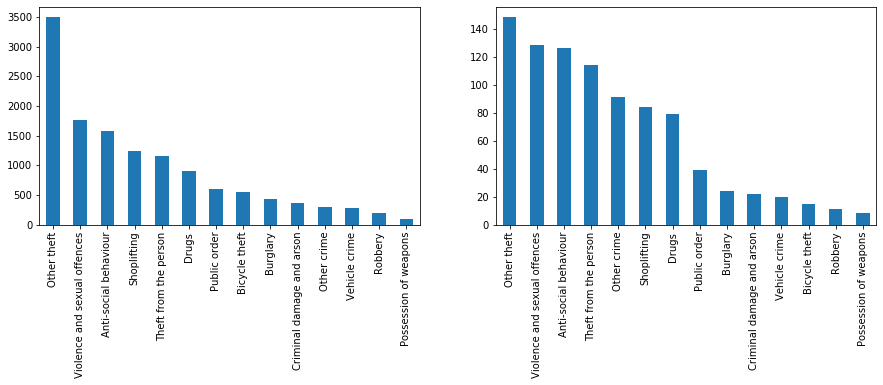

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15,4))

street_df.crime_type.value_counts().plot(kind='bar', ax = ax1)

# check the distribution of crime types for entries that have no location information
# see that they are distributed similarly to entire data
street_df[street_df.longitude.isnull()]['crime_type'].value_counts().plot(kind='bar', ax = ax2)

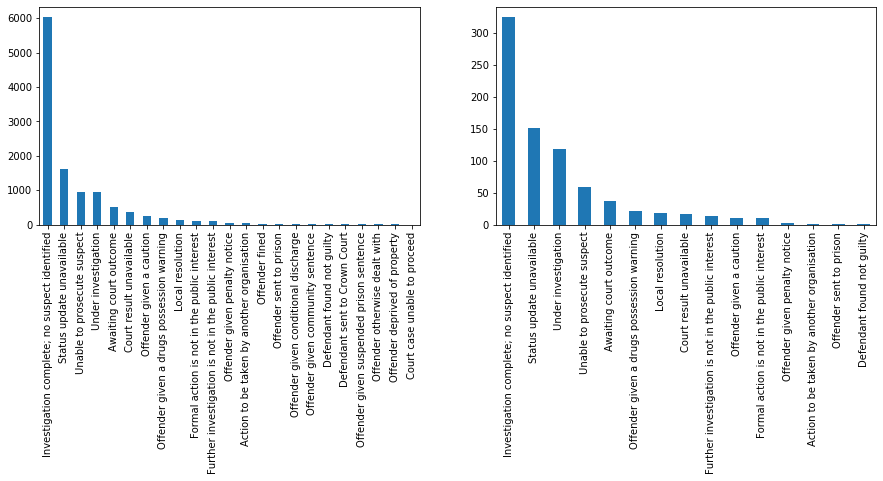

In [7]:
# compare the outcome distribution for the entire set versus those with no recorded location
# see that there is no clear difference among the outcomes either

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15,4))

street_df.last_outcome.value_counts().plot(kind='bar', ax=ax1)

street_df[street_df.longitude.isnull()].last_outcome.value_counts().plot(kind='bar', ax=ax2)

In [8]:
# no particular month that has way more null entries than others
street_df[street_df.longitude.isnull()].month.value_counts()

2019-08    81
2019-11    80
2019-12    79
2018-12    70
2020-01    68
2019-06    67
2019-09    65
2019-03    55
2020-02    54
2019-10    54
2019-05    47
2019-04    47
2019-07    41
2020-03    41
2019-01    31
2019-02    29
Name: month, dtype: int64

In [9]:
street_df[street_df.month == '2019-03'].crime_type.value_counts()

Other theft                     257
Violence and sexual offences    137
Anti-social behaviour           137
Shoplifting                     102
Theft from the person            48
Drugs                            41
Public order                     36
Bicycle theft                    30
Burglary                         28
Criminal damage and arson        23
Robbery                          13
Other crime                      12
Vehicle crime                    10
Possession of weapons             5
Name: crime_type, dtype: int64

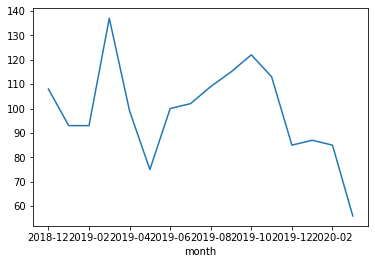

In [10]:
street_df[street_df.crime_type == 'Anti-social behaviour'].groupby('month')['crime_type'].count().plot()

In [11]:
df = street_df.groupby(['crime_type','month'])[['crime_type']].count().rename(columns = {'crime_type': 'counts'}).reset_index()

In [14]:
fig = go.Figure()

# Add surface trace

crime_ls = pd.Series(df.crime_type.unique())

for crime in crime_ls:
    fig.add_trace(
        go.Scatter(x=list(df[df.crime_type == crime].month),
                   y=list(df[df.crime_type == crime].counts),
                   name=crime,
                  visible=True))
                   #line=dict(color="#33CFA5")))

# Update plot sizing
fig.update_layout(
    width=800,
    height=900,
    autosize=False,
    margin=dict(t=0, b=0, l=0, r=0),
    template="plotly_white",
)

# Update 3D scene options
fig.update_scenes(
    aspectratio=dict(x=1, y=1, z=0.7),
    aspectmode="manual"
)


def create_layout_button(crime):
        return dict(label = crime,
                    method = 'update',
                    args = [{'visible': crime_ls.isin([crime]),
                             'title': crime,
                             'showlegend': True}])
    
button_all = dict(label = 'All',
                  method = 'update',
                  args = [{'visible': crime_ls.isin(crime_ls),
                           'title': 'All Crimes',
                           'showlegend':True}])

fig.update_layout(
     height=400, width = 900,
    updatemenus=[go.layout.Updatemenu(
        active = 0,
        pad={"r": 10, "t": 10},
        showactive=True,
        x=0.1,
        xanchor="left",
        y=1.25,
        yanchor="top",
        buttons =  [button_all] + list(crime_ls.map(
            lambda crime: create_layout_button(crime)))
        )])

fig.show()

### Geographical analysis

In [171]:
from shapely.geometry import Point, Polygon
#https://skgrange.github.io/data.html

In [169]:
boroughs = gpd.read_file('data/london_boroughs.json')

In [182]:
gdf = gpd.GeoDataFrame(
    street_df, geometry=gpd.points_from_xy(street_df.longitude, street_df.latitude))

In [202]:
#gdf = gpd.sjoin(gdf, boroughs, how='left', op='within')